In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My\ Drive/Projects/TimeSeriesForecasting

/content/drive/My Drive/Projects/TimeSeriesForecasting


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [0]:
from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv1D, Dense, Dropout, Flatten

In [0]:
os.makedirs('forecasts', exist_ok=True)
os.makedirs('forecasts/full_testing_length', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time', exist_ok=True)

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [0]:
class Args:
  def __init__(self):
    self.val_start = 12*24*250
    self.test_start = 12*24*300
    self.train_seq_len = 12*24*7
    self.val_seq_len = 12*24
    
    self.batch_size = 256
    self.num_epochs = 25
    self.save_folder = 'vanillaWaveNet_256_channels'
    
    self.conv_num_channels = 256
    self.kernel_size = 12
    self.dilation_rates = [2**i for i in range(8)] 

In [0]:
args = Args()

In [0]:
os.makedirs('forecasts/full_testing_length/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/plots', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results', exist_ok=True)

In [0]:
train_df = df[: args.val_start]
val_df = df[args.val_start: args.test_start]
test_df = df[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data.values[i - train_seq_len: i].T.tolist())
        y.append(data.values[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [0]:
history_seq = Input(shape=(args.train_seq_len, 1))
x = history_seq

for dilation_rate in args.dilation_rates:
    x = Conv1D(filters = args.conv_num_channels,
               kernel_size = args.kernel_size, 
               padding = 'causal',
               dilation_rate = dilation_rate)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(.2)(x)
x = Flatten()(x)
x = Dense(args.val_seq_len)(x)

model = Model(history_seq, x)

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2016, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2016, 256)         3328      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2016, 256)         786688    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2016, 256)         786688    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2016, 256)         786688    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2016, 256)         786688    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2016, 256)         7866

In [0]:
best_epoch = 24 #load this epoch (performance across epochs measured in respective model training notebook) 
model.load_weights('model_checkpoints/' + args.save_folder + '/model_{:02d}.h5'.format(best_epoch))
best_epoch

24

In [0]:
X_test, y_test = make_windows(test_df)

100%|██████████| 12097/12097 [00:01<00:00, 8538.48it/s]


In [0]:
y_pred = model.predict(X_test)

In [0]:
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  plt.plot(scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)), color = 'blue')
  plt.plot(scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)), color = 'red')
  plt.legend(['Actual Value', 'Prediction'])
  plt.savefig('forecasts/1_day_at_a_time/' + args.save_folder + '/plots/day_{}.png'.format(i))
  plt.close()

  df_t = po.DataFrame()
  df_t['Predictions'] = scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)
  df_t['Actual_Values'] = scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)

  df_t.to_csv('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results/day_{}.csv'.format(i), index = False)

100%|██████████| 42/42 [00:06<00:00,  6.34it/s]


In [0]:
forecasts = []
actuals = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()

100%|██████████| 42/42 [00:00<00:00, 1890.30it/s]


In [0]:
df = po.DataFrame()
df['Predictions'] = forecasts
df['Actual Values'] = actuals

In [0]:
df.to_csv('forecasts/full_testing_length/' + args.save_folder + '/full_results.csv', index = False)

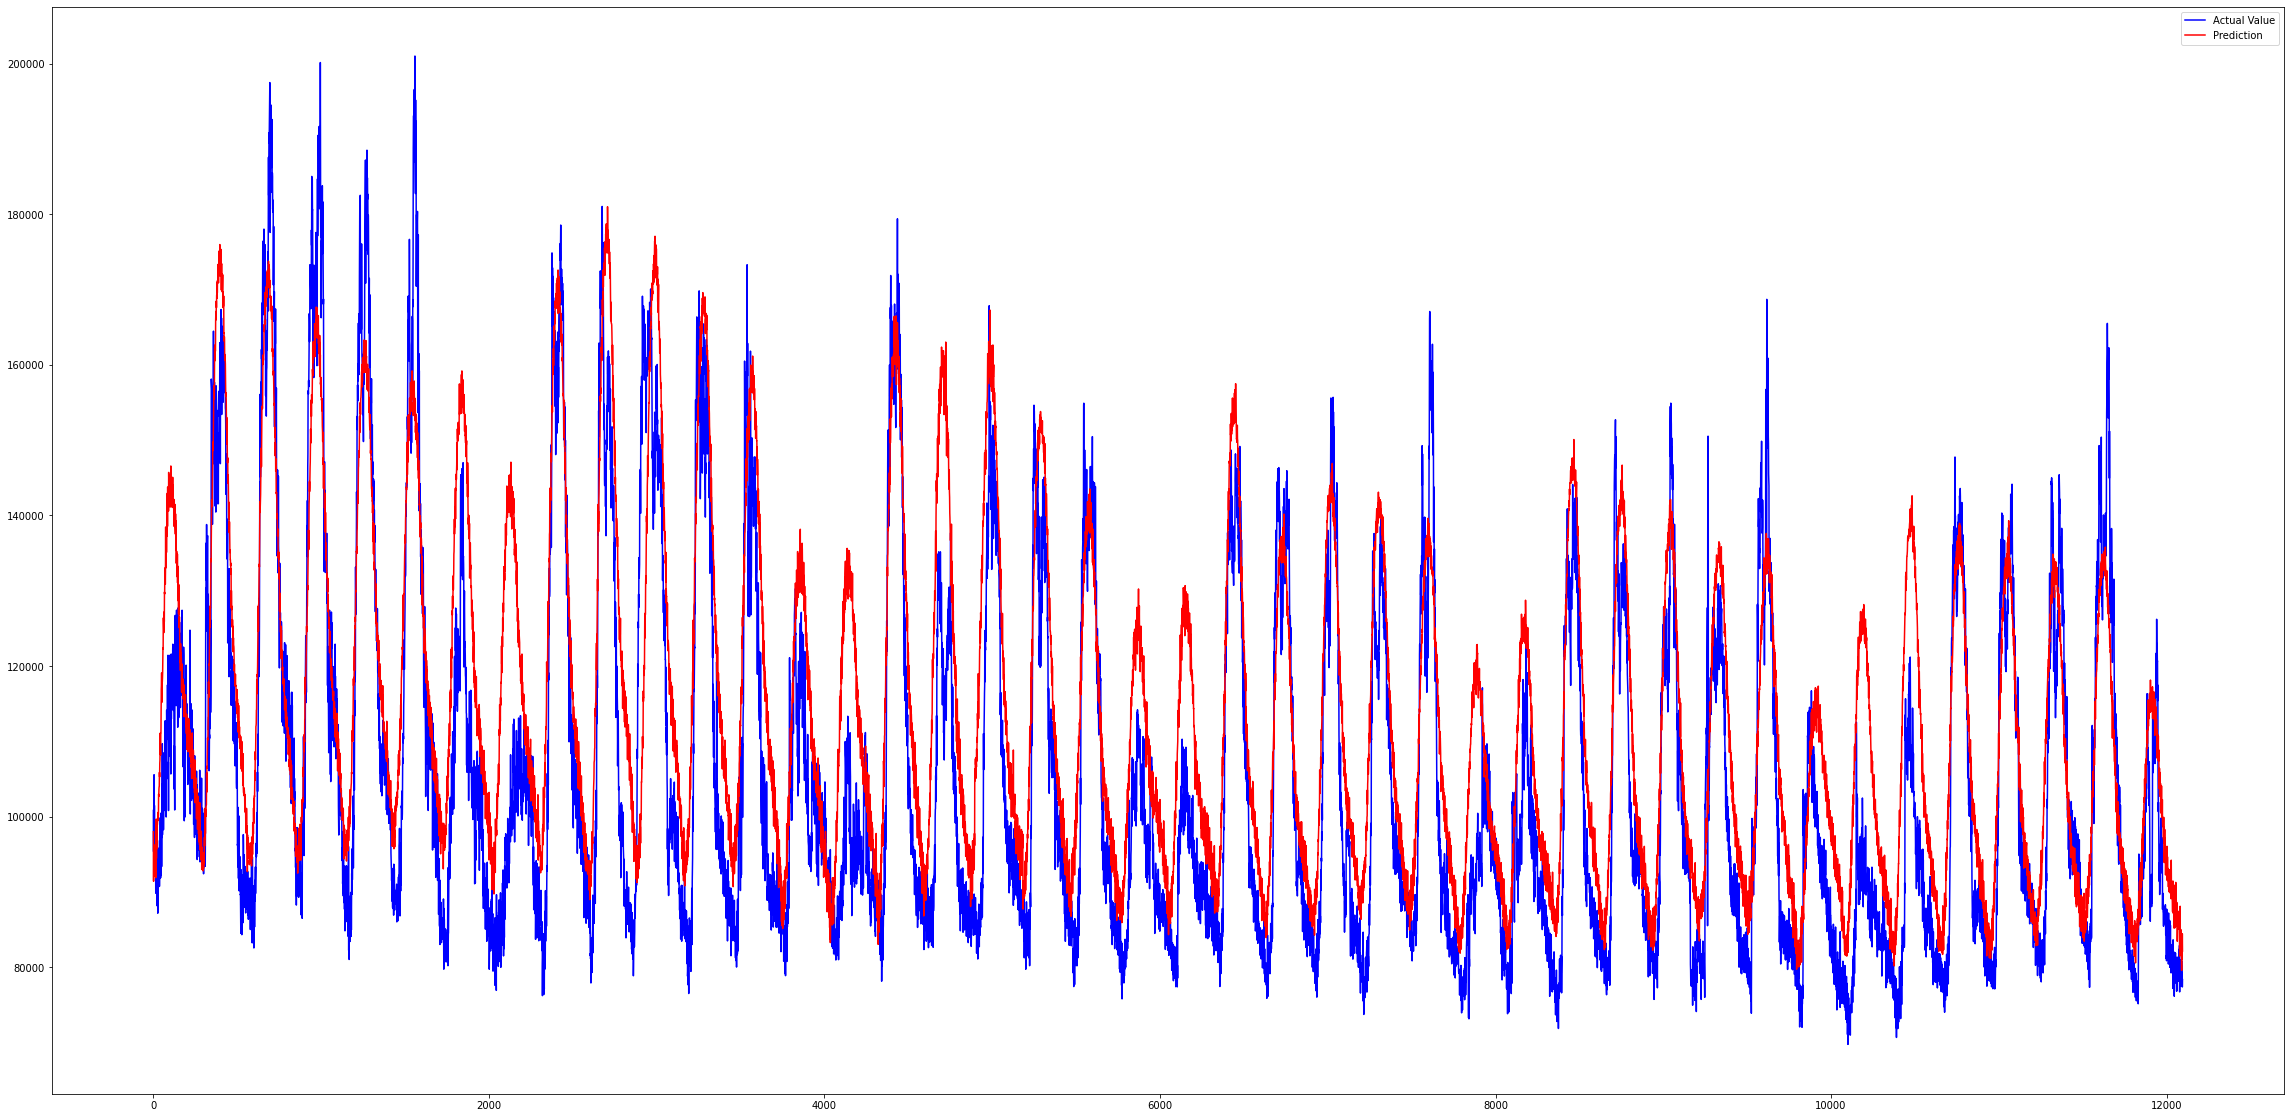

In [0]:
plt.figure(figsize=(40, 20))
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])
plt.savefig('forecasts/full_testing_length/' + args.save_folder + '/forecast.png')

In [0]:
if not os.path.exists('forecasts/full_testing_length/results.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2', 'MAPE', 'RMSE'])  
else:
  results = po.read_csv('forecasts/full_testing_length/results.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [0]:
results

,model,MAE,MSE,R2,MAPE,RMSE
0,Dilated_CNN,0.037945,0.002629,0.732376,3.794527,0.051273
1,vanillaWaveNet_256_channels,0.046997,0.003457,0.648037,4.699682,0.058799


In [0]:
results.to_csv('forecasts/full_testing_length/results.csv', index=False)

In [0]:
with open('forecasts/full_testing_length/' + args.save_folder + '/params.json', 'w') as f:
  f.write(json.dumps(args.__dict__))
f.close()